   # Validation of static solver
   Studies consider a flat plate model.

In [1]:
import os,sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

import uvlm2d_sta as uvlm
import pp_uvlm2d as pp 

## Numerical vs. analytical
The vorticity distrubution along a flat plate can be derived analytically under the assumptions of small angles of attack (Anderson, Sec.4.7). These methods are implemented into uvlm2d.solver.analytical. 

### 1 Lumped vortex solution

We start deriving a solution with only 1 vortex element discretising the flat plate. Note that the length of the wake has no relevance, as the jump in vorticity is constant along the wake if the flow is steady.

In [2]:
# input
Mw=2
M=1
alpha=2.*np.pi/180.
chord=3.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225
S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
# build geometry and solve
S.build_flat_plate()
S.solve_static_gamma2d()
# derive reference solution
S.analytical()

../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)


The vorticity of the lumped vortex is equal to the total vorticity expected analytically:

In [3]:
print('Lumped vorticity = %f' %S.Gamma[0])
print('Analytical total vorticity = %f' %S.GammaTot_an)

Lumped vorticity = -6.578400
Analytical total vorticity = -6.579736


and the total force acting on the aerofoil is:

In [4]:
# Aero forces
Ftot=S.Faero.sum(0)
print('Total force: Fx=%f , Fy=%f' %tuple(Ftot))
print('Total lift (analytical) = %f' %S.Lift_an)

Total force: Fx=0.000000 , Fy=161.170804
Total lift (analytical) = 161.203539


which correspond to a $CL_\alpha$ of $2\pi$:

In [5]:
print('CLa numerical = %f'%(Ftot[1]/S.qinf/S.chord/S.alpha))
print('CLa analytical = %f'%(S.Lift_an/S.qinf/S.chord/S.alpha))

CLa numerical = 6.281909
CLa analytical = 6.283185


The position of the aerodynamic center, $\eta_{LE}$ is also computed. As a double check, we can also compute the moment about the 25% chord line, which is practically zero.

In [6]:
Mte=0.0
for nn in range(S.K):
    Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
rAC=np.zeros((2,))
rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
# AC calculation
rLE=S.Rmat[0,:]
etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])

print('computed position of AC from LE (non-dimensional) = %f' %etaLE)
print('Aero moment about 25 perc chord = %f' %Mac)

computed position of AC from LE (non-dimensional) = 0.250000
Aero moment about 25 perc chord = 0.000000


### M>1 solution

We now re-compute the solution for a larger number of elements bound vortices (M) and look at other quantities such as the vorticity distribution along the aerofoil and the position of the aerodynamic center. As before, the amount of vortices in the wake has no relevance. 

In [7]:
# input
Mw=2
M=100
alpha=2.*np.pi/180.
chord=3.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225
S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
# build geometry and solve
S.build_flat_plate()
S.solve_static_gamma2d()
# derive reference solution
S.analytical()

../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)


The total vorticity distribution compares well against the analitical solution:

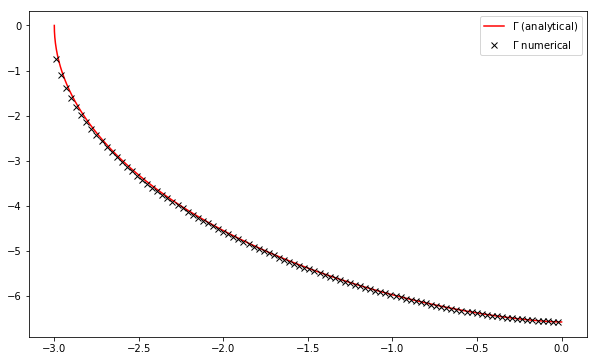

In [8]:
fig=plt.figure('Total vorticity', figsize=[10.,6.0])
ax=fig.add_subplot(111)
ax.plot(S.xvec_an,S.Gamma_an,'r',label=r'$\Gamma$ (analytical)')
ax.plot(S.Zeta[:-1,0],S.Gamma,'kx',label=r'$\Gamma$ numerical')
ax.legend()
plt.show()

The force distribution along the span is:

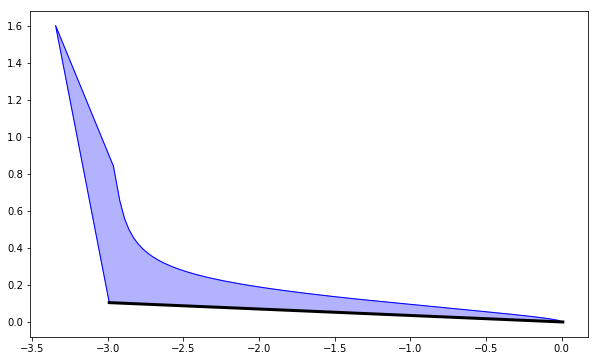

In [9]:
pp.force_distr(S)
plt.show()

and shows lead edge suction. The total force and moments are:

In [10]:
# Aero forces
Ftot=S.Faero.sum(0)
Mte=0.0
for nn in range(S.K):
    Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
rAC=np.zeros((2,))
rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
# AC calculation
rLE=S.Zeta[0,:]
etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
# Aero coeff.s
CF=Ftot/(2.*S.b*S.qinf)/S.alpha
CM=Mac/(4.*S.b**2*S.qinf)/S.alpha

The total vorticity ($\Gamma_{TE}$) is close to the one predicted analytically:

In [11]:
print('Numerical total vorticity = %f' %S.Gamma[-1])
print('Analytical total vorticity = %f' %S.GammaTot_an)

Numerical total vorticity = -6.578400
Analytical total vorticity = -6.579736


and the total force acting on the aerofoil is:

In [12]:
# Aero forces
Ftot=S.Faero.sum(0)
print('Total force: Fx=%f , Fy=%f' %tuple(Ftot))
print('Total lift (analytical) = %f' %S.Lift_an)

Total force: Fx=-0.000000 , Fy=161.170804
Total lift (analytical) = 161.203539


which correspond to a $CL_\alpha$ of $2\pi$:

In [13]:
print('CLa numerical = %f'%(Ftot[1]/S.qinf/S.chord/S.alpha))
print('CLa analytical = %f'%(S.Lift_an/S.qinf/S.chord/S.alpha))

CLa numerical = 6.281909
CLa analytical = 6.283185


Note that, despite the LE suction, the total horizontal force is positive - induced drag. 

Note that the total moment about the point at 0.25% of the chord is almost zero:

In [14]:
print('Mac = %f' %Mac)
print('Cmac = %f'%CM)

Mac = 0.000000
Cmac = 0.000000


In fact, the position of the Ac computed numerically is:

In [15]:
print('zetaAC/chord= %f'%etaLE)

zetaAC/chord= 0.248120


In summary, the solution is good. Note that in this model the plate is at an angle w.r.t. the frame of reference but the free stream velocity is along the x axis. Also, the plate is assumed to have no motion.

## Solutions at different angles
We verify that:
- the derivative of the lift coefficient is constant
- the drag is always zero
- the aerodynamic moment about the quarter chord line is zero
- the aerodynamic center is at 25% of the chord (this check is redundant if the previous is verified)

In [16]:
# input
M=40
Mw=2
chord=2.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

Na=41
Alphavec=np.linspace(-20,20,Na)*np.pi/180.
CLavec,CDavec=np.zeros((Na,)), np.zeros((Na,))
CMavec=np.zeros((Na,))
EtaLEvec=np.zeros((Na,))

for aa in range(Na):

    alpha=Alphavec[aa]

    S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    # build geometry and solve
    S.build_flat_plate()
    S.solve_static_gamma2d()
    # derive reference solution
    S.analytical()

    # Aero forces
    Ftot=S.Faero.sum(0)
    Mte=0.0
    for nn in range(S.K):
        Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
    rAC=np.zeros((2,))
    rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
    rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
    Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
    # AC calculation
    rLE=S.Rmat[0,:]
    etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
    # Aero coeff.s
    CF=Ftot/(2.*S.b*S.qinf)/S.alpha
    CM=Mac/(4.*S.b**2*S.qinf)/S.alpha
    
    CDavec[aa]=CF[0]
    CLavec[aa]=CF[1]
    CMavec[aa]=CM
    EtaLEvec[aa]=etaLE

    print('alpha %.2f deg completed!' %(alpha*180./np.pi))



../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)


alpha -20.00 deg completed!
alpha -19.00 deg completed!
alpha -18.00 deg completed!
alpha -17.00 deg completed!
alpha -16.00 deg completed!
alpha -15.00 deg completed!
alpha -14.00 deg completed!
alpha -13.00 deg completed!
alpha -12.00 deg completed!
alpha -11.00 deg completed!
alpha -10.00 deg completed!
alpha -9.00 deg completed!
alpha -8.00 deg completed!
alpha -7.00 deg completed!
alpha -6.00 deg completed!
alpha -5.00 deg completed!
alpha -4.00 deg completed!
alpha -3.00 deg completed!
alpha -2.00 deg completed!
alpha -1.00 deg completed!


../uvlm2d_sta.py:706: RuntimeWarning: invalid value encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


alpha 0.00 deg completed!
alpha 1.00 deg completed!
alpha 2.00 deg completed!
alpha 3.00 deg completed!
alpha 4.00 deg completed!
alpha 5.00 deg completed!
alpha 6.00 deg completed!
alpha 7.00 deg completed!
alpha 8.00 deg completed!
alpha 9.00 deg completed!
alpha 10.00 deg completed!
alpha 11.00 deg completed!
alpha 12.00 deg completed!
alpha 13.00 deg completed!
alpha 14.00 deg completed!
alpha 15.00 deg completed!
alpha 16.00 deg completed!
alpha 17.00 deg completed!
alpha 18.00 deg completed!
alpha 19.00 deg completed!
alpha 20.00 deg completed!


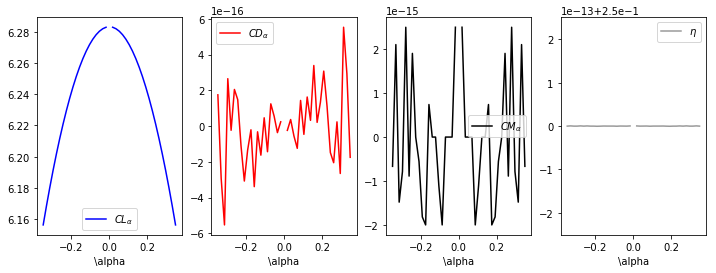

In [17]:
fig=plt.figure('Force coefficients vs alpha', figsize=[12.,4.0])
ax = fig.add_subplot(141)
ax.plot(Alphavec,CLavec,'b',label=r'$CL_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(142)
plt.plot(Alphavec,CDavec,'r',label=r'$CD_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(143)
plt.plot(Alphavec,CMavec,'k',label=r'$CM_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(144)
plt.plot(Alphavec,EtaLEvec[:],'0.6',label=r'$\eta$')
ax.set_xlabel(r'\alpha')
ax.legend()
plt.show()

Comment:
- the CLa is constant, and very close to $2\pi$
- the CDa is numerically zero.
- the CMa about the 25% of the chord is very close to zero.
- the AC is always close to the 25% of the chord.

## Validation of solution with $\Gamma$

The numerical solution above is w.r.t. $\gamma_i=\Gamma_i - \Gamma_{i-1}$, and the $\Gamma$ distribution is derived in a second stage. We can, however, also solve for the $\Gamma$ distribution directly. This soilution is verified below

In [18]:
# input
M=40
chord=2.
Mw=2
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

Na=21
Alphavec=np.linspace(-10,10,Na)*np.pi/180.
CLavec,CDavec=np.zeros((Na,)), np.zeros((Na,))
CMavec=np.zeros((Na,))
EtaLEvec=np.zeros((Na,))

for aa in range(Na):

    alpha=Alphavec[aa]

    S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    # build geometry and solve
    S.build_flat_plate()
    S.solve_static_Gamma2d()
    # derive reference solution
    S.analytical()

    # Aero forces
    Ftot=S.Faero.sum(0)
    Mte=0.0
    for nn in range(S.M):
        Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
    rAC=np.zeros((2,))
    rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
    rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
    Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
    # AC calculation
    rLE=S.Rmat[0,:]
    etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
    # Aero coeff.s
    CF=Ftot/(2.*S.b*S.qinf)/S.alpha
    CM=Mac/(4.*S.b**2*S.qinf)/S.alpha
    
    CDavec[aa]=CF[0]
    CLavec[aa]=CF[1]
    CMavec[aa]=CM
    EtaLEvec[aa]=etaLE

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:
../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
../uvlm2d_sta.py:706: RuntimeWarning: invalid value encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars


Though no one to one comparison was made, it is easty to verify that the trends below are identical to those obtained solving for $\gamma$.

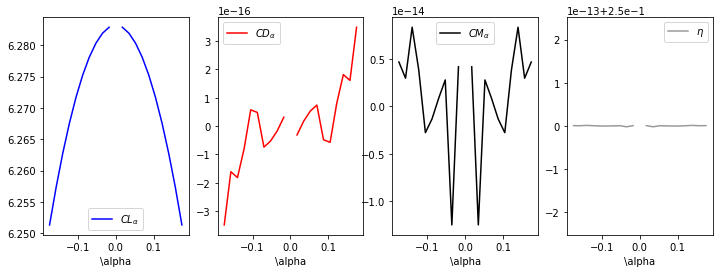

In [19]:
fig=plt.figure('Force coefficients vs alpha', figsize=[12.,4.0])
ax = fig.add_subplot(141)
ax.plot(Alphavec,CLavec,'b',label=r'$CL_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(142)
plt.plot(Alphavec,CDavec,'r',label=r'$CD_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(143)
plt.plot(Alphavec,CMavec,'k',label=r'$CM_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(144)
plt.plot(Alphavec,EtaLEvec[:],'0.6',label=r'$\eta$')
ax.set_xlabel(r'\alpha')
ax.legend()
plt.show()

## Effect of vortex grid position
Is is really necessary to displace the vortices grid a quarter-line behind the wing panels? Below, we derive the solution assuming that the vortex-grid coincides with the geometry grid. 

In [20]:
# input
M=40
chord=2.
Mw=2
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

Na=21
Alphavec=np.linspace(-10,10,Na)*np.pi/180.
CLavec,CDavec=np.zeros((Na,)), np.zeros((Na,))
CMavec=np.zeros((Na,))
EtaLEvec=np.zeros((Na,))

for aa in range(Na):

    alpha=Alphavec[aa]

    S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
    S.perc_ring=0.0
    
    # build geometry and solve
    S.build_flat_plate()
    S.solve_static_Gamma2d()
    # derive reference solution
    S.analytical()

    # Aero forces
    Ftot=S.Faero.sum(0)
    Mte=0.0
    for nn in range(S.K):
        Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
    rAC=np.zeros((2,))
    rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
    rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
    Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
    # AC calculation
    rLE=S.Rmat[0,:]
    etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
    # Aero coeff.s
    CF=Ftot/(2.*S.b*S.qinf)/S.alpha
    CM=Mac/(4.*S.b**2*S.qinf)/S.alpha
    
    CDavec[aa]=CF[0]
    CLavec[aa]=CF[1]
    CMavec[aa]=CM
    EtaLEvec[aa]=etaLE

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:
../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
../uvlm2d_sta.py:706: RuntimeWarning: invalid value encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in double_scalars


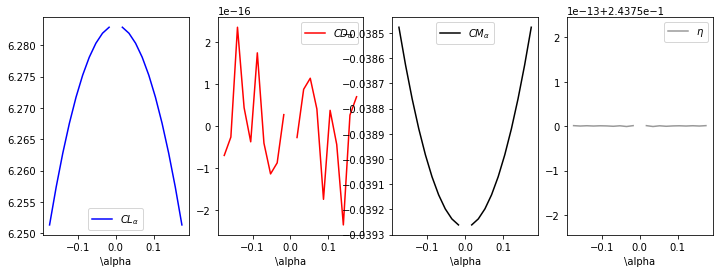

In [21]:
fig=plt.figure('Force coefficients vs alpha', figsize=[12.,4.0])
ax = fig.add_subplot(141)
ax.plot(Alphavec,CLavec,'b',label=r'$CL_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(142)
plt.plot(Alphavec,CDavec,'r',label=r'$CD_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(143)
plt.plot(Alphavec,CMavec,'k',label=r'$CM_\alpha$')
ax.set_xlabel(r'\alpha')
ax.legend()
ax = fig.add_subplot(144)
plt.plot(Alphavec,EtaLEvec[:],'0.6',label=r'$\eta$')
ax.set_xlabel(r'\alpha')
ax.legend()
plt.show()

Results are very close to those obtained with shifted vortex rings. Below, we analyse further the convergence properties of the two discretisations. Note that in both cases the collocation point is in the middle of the vortex ring.

In [22]:
# input
Mvec=[1,2,4,8,16,32,64,128]
Mw=2
chord=2.
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225
alpha=5.*np.pi/180.

Nm=len(Mvec)
CLavec,CDavec=np.zeros((Nm,2)), np.zeros((Nm,2))
CMavec=np.zeros((Nm,2))
EtaLEvec=np.zeros((Nm,2))

for mm in range(Nm):

    ################################################
    S=uvlm.solver(Mvec[mm],Mw,b,Uinf,alpha,rho=1.225)
    # build geometry with shift
    S.perc_ring=0.25
    S.build_flat_plate()
    S.solve_static_Gamma2d()
    # Aero forces
    Ftot=S.Faero.sum(0)
    Mte=0.0
    for nn in range(S.K):
        Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
    rAC=np.zeros((2,))
    rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
    rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
    Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
    # AC calculation
    rLE=S.Rmat[0,:]
    etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
    # Aero coeff.s
    CF=Ftot/(2.*S.b*S.qinf)/S.alpha
    CM=Mac/(4.*S.b**2*S.qinf)/S.alpha
    CDavec[mm,0]=CF[0]
    CLavec[mm,0]=CF[1]
    CMavec[mm,0]=CM
    EtaLEvec[mm,0]=etaLE
    
    ################################################
    S=uvlm.solver(Mvec[mm],Mw,b,Uinf,alpha,rho=1.225)
    # build geometry without shift
    S.perc_ring=0.0
    S.build_flat_plate()
    S.solve_static_Gamma2d()
    # Aero forces
    Ftot=S.Faero.sum(0)
    Mte=0.0
    for nn in range(S.K):
        Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
    rAC=np.zeros((2,))
    rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
    rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
    Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
    # AC calculation
    rLE=S.Rmat[0,:]
    etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
    # Aero coeff.s
    CF=Ftot/(2.*S.b*S.qinf)/S.alpha
    CM=Mac/(4.*S.b**2*S.qinf)/S.alpha
    CDavec[mm,1]=CF[0]
    CLavec[mm,1]=CF[1]
    CMavec[mm,1]=CM
    EtaLEvec[mm,1]=etaLE

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


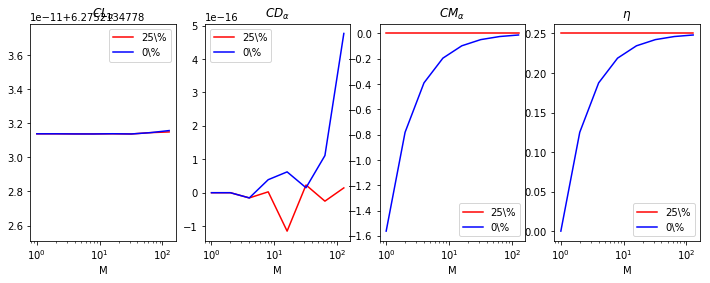

In [23]:
fig=plt.figure('Force coefficients vs M', figsize=[12.,4.0])
ax = fig.add_subplot(141)
ax.set_title(r'$CL_\alpha$')
ax.semilogx(Mvec,CLavec[:,0],'r',label=r'25\%')
ax.semilogx(Mvec,CLavec[:,1],'b',label=r'0\%')
ax.set_xlabel(r'M')
ax.legend()
ax = fig.add_subplot(142)
ax.set_title(r'$CD_\alpha$')
ax.semilogx(Mvec,CDavec[:,0],'r',label=r'25\%')
ax.semilogx(Mvec,CDavec[:,1],'b',label=r'0\%')
ax.set_xlabel(r'M')
ax.legend()
ax = fig.add_subplot(143)
ax.set_title(r'$CM_\alpha$')
ax.semilogx(Mvec,CMavec[:,0],'r',label=r'25\%')
ax.semilogx(Mvec,CMavec[:,1],'b',label=r'0\%')
ax.set_xlabel(r'M')
ax.legend()
ax = fig.add_subplot(144)
ax.set_title(r'$\eta$')
ax.semilogx(Mvec,EtaLEvec[:,0],'r',label=r'25\%')
ax.semilogx(Mvec,EtaLEvec[:,1],'b',label=r'0\%')
ax.set_xlabel(r'M')
ax.legend()
plt.show()

As expected, shifting the vortex panels ensures a much faster convergence of the aerodynamic moment. As M is increased, the methods are equivalent. The lift and drag  are, instead, always comparable.

## Verify aerofoil motion and large deflections
In this section we verify that the impact of the aerofoil motion and the large amplitude deflections (of both the aerofoil and the incoming flow) is well captured.

### Large deflections
Here the free stream and the aerofoil have an angle $\alpha_{eff}$, while the aerofil is at an angle $\alpha$ between the free stream - i.e., the free stream is not aligned with the x axis.

As seen below, the force coefficients in wind axis are the same for the two solutions.

Note that in the current implementation of the solver, the attribute alpha of the S class indicates the angle between the plate and the horizontal line, and not the effective angle of attack between free stream velocity and aerofoil.

In [24]:
# input
M=30
Mw=2
chord=2.
b=0.5*chord
Uabs=20.

################################## Reference
Uinf=np.array([Uabs,0.])
alpha_eff=5.*np.pi/180.
S=uvlm.solver(M,Mw,b,Uinf,alpha_eff,rho=1.225)
# build geometry with shift
S.perc_ring=0.25
S.build_flat_plate()
S.solve_static_Gamma2d()
# Aero forces
Ftot=S.Faero.sum(0)
# Aero coeff.s
CF_ref=Ftot/(2.*S.b*S.qinf)/alpha_eff
print('Reference Force in G and wind frame:')
print(Ftot)
print('absolute value: %f' %np.linalg.norm(Ftot))

################################## Rotated system
alpha_u=30.0*np.pi/180.0
Uinf=Uabs*np.array([np.cos(alpha_u),np.sin(alpha_u)])
alpha_eff=5.*np.pi/180.
S=uvlm.solver(M,Mw,b,Uinf,alpha_eff-alpha_u,rho=1.225)
# build geometry with shift
S.perc_ring=0.25
S.build_flat_plate()
S.solve_static_Gamma2d()
# Aero forces
Ftot=S.Faero.sum(0)
Fwind=np.zeros((2,))
Uperp=np.array([-S.Udir[1],S.Udir[0]])
Fwind[0]=np.dot(Ftot,S.Udir)
Fwind[1]=np.dot(Ftot,Uperp)

print('Current Force in G frame:')
print(Ftot)
print('Current Force in wind frame:')
print(Fwind)

CF_rot=Fwind/(2.*S.b*S.qinf)/alpha_eff 
print('Force coefficients (always projected in wind axes)')
print('CF reference: %f %f'%tuple(CF_ref))
print('CF current: %f %f'%tuple(CF_rot))

Reference Force in G and wind frame:
[  9.65894031e-15   2.68331684e+02]
absolute value: 268.331684
Current Force in G frame:
[-134.16584216  232.38205525]
Current Force in wind frame:
[ -4.26325641e-14   2.68331684e+02]
Force coefficients (always projected in wind axes)
CF reference: 0.000000 6.275213
CF current: -0.000000 6.275213


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


### Vertical velocity of the aerofoil

Here the aerofoil is at a zero angle with respect to the free stream velocity, but has a velocity perpendicular to the free stream. Both aerofoil and free stream speed are rotated w.r.t. the horizontal line.

Note that this case is slightly inconsistent: if the aerofoil has a constant velocity, its wake does not develop along the free stream velocity, but on the sum between the free stream and the TE velocity. Because the wake does not impact the static solution, this is not accounted in the geometry.

In [25]:
##############################Rotated system + speed
alpha_u=30.0*np.pi/180.0
Uinf=Uabs*np.array([np.cos(alpha_u),np.sin(alpha_u)])
S=uvlm.solver(M,Mw,b,Uinf,-alpha_u,rho=1.225)
# build geometry with shift
S.build_flat_plate()
Uperp=np.array([-S.Udir[1],S.Udir[0]])
alpha_eff=5.*np.pi/180.
Uplate_mag=S.Uabs*np.sin(alpha_eff)
Uplate=-Uplate_mag*Uperp
S.dZetadt[:,:]=Uplate
S.solve_static_Gamma2d()
# Aero forces
Ftot=S.Faero.sum(0)
print('Current Force in G frame:')
print(Ftot)

# compute effective velocity
Utot=Uinf-Uplate
Utot_abs=np.linalg.norm(Utot)
Utot_dir=Utot/Utot_abs
Utot_perp=np.array([-Utot_dir[1],Utot_dir[0]])
# project over effect velocity axis
Fwind=np.zeros((2,))
Fwind[0]=np.dot(Ftot,Utot_dir)
Fwind[1]=np.dot(Ftot,Utot_perp)
print('Current Force in wind frame:')
print(Fwind)

CF_rot=Fwind/(2.*S.b*S.qinf)/alpha_eff 
print('Force coefficients (always projected in wind axes)')
print('CF reference: %f %f'%tuple(CF_ref))
print('CF current: %f %f'%tuple(CF_rot))

Current Force in G frame:
[-154.41927278  220.68873163]
Current Force in wind frame:
[ -4.26325641e-14   2.69348897e+02]
Force coefficients (always projected in wind axes)
CF reference: 0.000000 6.275213
CF current: -0.000000 6.299002


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


This case is more complex, as the absolute effective velocity is larger due to the velocity of the plate. The aerodynamic coefficient match weel if projected in the effective wind axes. The match is not perfect as the effective velocities are different in the two cases and the code is not perfectly linear.

The agreement is, however, satisfactory.

# Cambered aerofoil
We compute the characteristic curves for a cambered aerofoil.

In [26]:
# input
M=51
chord=2.
Mw=2
b=0.5*chord
Uinf=np.array([20.,0.])
rho=1.225

Na=21
Alphavec=np.linspace(-15,15,Na)*np.pi/180.
Mcamb_vec=np.array([0,1,2,3])
Ncamb=len(Mcamb_vec)
CLavec,CDavec=np.zeros((Ncamb,Na)), np.zeros((Ncamb,Na))
CMavec=np.zeros((Ncamb,Na))
EtaLEvec=np.zeros((Ncamb,Na))

CF0vec=np.zeros((Ncamb,2))
CM0vec=np.zeros((Ncamb,))

for mm in range(Ncamb):
    Mcamb_here=Mcamb_vec[mm]
    
    for aa in range(Na):
        alpha=Alphavec[aa]

        S=uvlm.solver(M,Mw,b,Uinf,alpha,rho=1.225)
        # build geometry and solve
        S.build_camber_plate(Mcamb=Mcamb_here,Pcamb=0.4)
        S.solve_static_Gamma2d()
        # derive reference solution
        S.analytical()

        # Aero forces
        Ftot=S.Faero.sum(0)
        Mte=0.0
        for nn in range(S.K):
            Mte+=S.Faero[nn,1]*S.Zeta[nn,0]-S.Faero[nn,0]*S.Zeta[nn,1]
        rAC=np.zeros((2,))
        rAC[0]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,0])
        rAC[1]=np.interp(0.25*S.M,np.linspace(0,S.M,S.M+1),S.Rmat[:,1])
        Mac=Mte - (Ftot[1]*rAC[0] - Ftot[0]*rAC[1])
        # AC calculation
        rLE=S.Rmat[0,:]
        etaLE = 1. - Mte / (-Ftot[0]*rLE[1]+Ftot[1]*rLE[0])
        # Aero coeff.s
        CF=Ftot/(2.*S.b*S.qinf)#/S.alpha
        CM=Mac/(4.*S.b**2*S.qinf)#/S.alpha

        CDavec[mm,aa]=CF[0]
        CLavec[mm,aa]=CF[1]
        CMavec[mm,aa]=CM
        EtaLEvec[mm,aa]=etaLE
     
    CF0vec[mm,:]=[CDavec[mm,(Na-1)/2],CLavec[mm,(Na-1)/2]]
    CM0vec[mm]=CMavec[mm,(Na-1)/2]
    CDavec[mm,:]=(CDavec[mm,:]-CF0vec[mm,0])/Alphavec
    CLavec[mm,:]=(CLavec[mm,:]-CF0vec[mm,1])/Alphavec
    CMavec[mm,:]=(CMavec[mm,:]-CM0vec[mm])/Alphavec

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:
../uvlm2d_sta.py:706: RuntimeWarning: divide by zero encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
../uvlm2d_sta.py:706: RuntimeWarning: invalid value encountered in true_divide
  (1.+np.cos(thvec))/np.sin(thvec)
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in double_scalars
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/sm6110/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:56: RuntimeWarning: i

In [27]:
CLavec[0,:]

array([ 6.21165708,  6.2252097 ,  6.23735072,  6.24807516,  6.2573786 ,
        6.26525723,  6.2717078 ,  6.27672766,  6.28031475,  6.28246759,
               nan,  6.28246759,  6.28031475,  6.27672766,  6.2717078 ,
        6.26525723,  6.2573786 ,  6.24807516,  6.23735072,  6.2252097 ,
        6.21165708])

Though no one to one comparison was made, it is easty to verify that the trends below are identical to those obtained solving for $\gamma$.

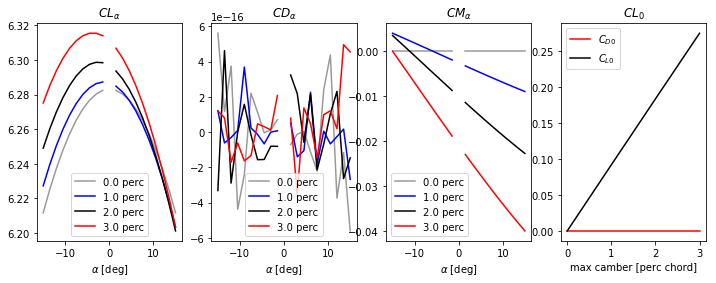

In [28]:
Clist=['0.6','b','k','r']
Labs=[r'%.1f perc' %Mcamb for Mcamb in Mcamb_vec]

fig=plt.figure('Force coefficients vs alpha', figsize=[12.,4.0])
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.set_title(r'$CL_\alpha$')
ax2.set_title(r'$CD_\alpha$')
ax3.set_title(r'$CM_\alpha$')
#ax4.set_title(r'$\eta$')

for mm in range(Ncamb):
    ax1.plot(180./np.pi*Alphavec,CLavec[mm,:],color=Clist[mm],label=Labs[mm])
    ax2.plot(180./np.pi*Alphavec,CDavec[mm,:],color=Clist[mm],label=Labs[mm])
    ax3.plot(180./np.pi*Alphavec,CMavec[mm,:],color=Clist[mm],label=Labs[mm])
    #ax4.plot(180./np.pi*Alphavec,EtaLEvec[mm,:],color=Clist[mm],label=Labs[mm])
ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.legend()
ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.legend()
ax3.set_xlabel(r'$\alpha$ [deg]')
ax3.legend()   
#ax4.set_xlabel(r'$\alpha$ [deg]')
#ax4.legend()

ax4.set_title(r'$CL_0$')
ax4.plot(Mcamb_vec,CF0vec[:,0],color='r',label=r'$C_{D0}$') 
ax4.plot(Mcamb_vec,CF0vec[:,1],color='k',label=r'$C_{L0}$')   
ax4.set_xlabel(r'max camber [perc chord]')
ax4.legend()

plt.show()

All force/moment coefficient derivatives are computed after subtracting the force/moment coefficient at $\alpha=0$, to avoid division by zero.

It can be noticed:
- the $C_{L0}$ increases with camber, while $C_{D0}$ is always zero;
- The $CL_\alpha$ is around $2 \pi$, as expected.
- the inviscid drag remains zero, as expected.
- The $C_{M\alpha}$ about the quarter-line chord is roughly zero;